In [1]:
using PyPlot

# Let's compare latency and throughput for an inference task

Simple linear model for multiclass regression.

$$\hat y(x) = \arg \max_{i \in \{1, \ldots, c\}} w_i^T x$$

In [2]:
# number of classes
c = 64;

# dimension of model
d = 256 * 1024;

# number of test examples
n = 1024;

# random weight matrix
w = randn(c, d);

# test examples
x = randn(d, n);

In [3]:
function predict(w::Array{Float64,2}, x::Array{Float64,2})
    wx = w*x;
    return [findmax(wx[:,i])[2] for i = 1:size(x,2)];
end

predict (generic function with 1 method)

Suppose we want to make a prediction for all $n = 1024$ test examples. How long will this take us?

In [4]:
# first run of predictions to make sure everything is compiled
predict(w, x);

# now time the time it takes to predict
(predictions, elapsed) = @timed predict(w, x);

println("latency: took $elapsed seconds to return predictions");
println("throughput: on average, $(n/(elapsed)) predictions/second");

latency: took 0.340027367 seconds to return predictions
throughput: on average, 3011.522304909063 predictions/second


Now what if we make a prediction for just one isolated example?

In [5]:
(predictions, elapsed) = @timed predict(w, x[:,1:1]);

println("latency: took $elapsed seconds to return predictions");
println("throughput: on average, $(1/(elapsed)) predictions/second");

latency: took 0.07215254 seconds to return predictions
throughput: on average, 13.859525943230826 predictions/second


What happened?

The latency went down, but so did the throughput.

This exposes a tradeoff: if we can batch examples to be inferred, we can usually raise the throughput...but this comes at a cost of higher latency!

In [6]:
batch_size = [1,2,4,8,16,32,64,128,256,512,1024];
latencies = zeros(length(batch_size));
throughputs = zeros(length(batch_size));

for i = 1:length(batch_size)
    xsi = copy(x[:,1:batch_size[i]]);
    (predictions, elapsed) = @timed predict(w, xsi);
    
    latencies[i] = elapsed;
    throughputs[i] = batch_size[i] / elapsed;
end

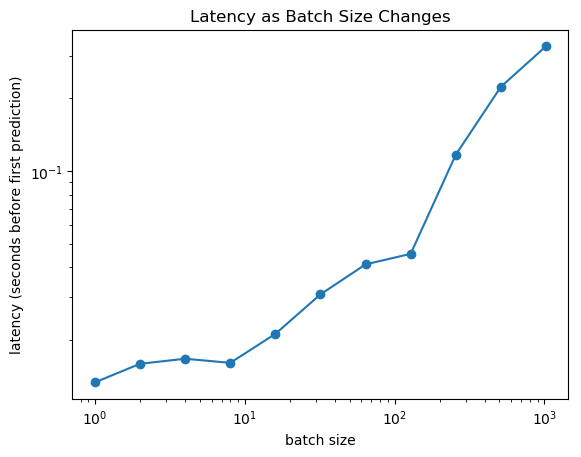

In [7]:
loglog(batch_size, latencies, "-o");
title("Latency as Batch Size Changes");
xlabel("batch size");
ylabel("latency (seconds before first prediction)");

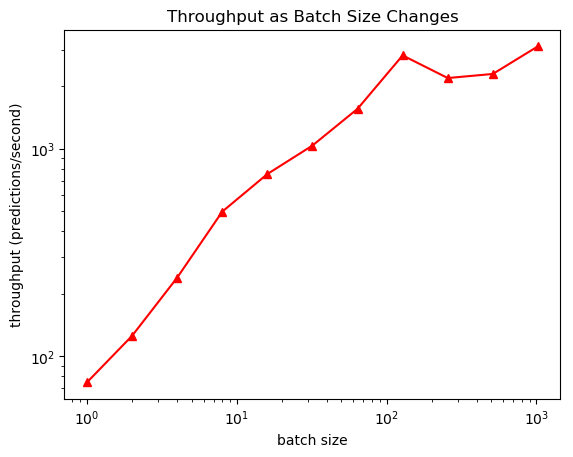

In [8]:
loglog(batch_size, throughputs, "-^r");
title("Throughput as Batch Size Changes");
xlabel("batch size");
ylabel("throughput (predictions/second)");